In [57]:
import numpy as np
import pandas as pd
import math

###### Paper1 ######
class Crowsensing_env:
    def __init__(self, B, N, K, c_min, alpha, seed = 4530):
        np.random.seed(seed)
        self.c_min = c_min
        self.c_max = 1
        self.B = B
        self.N = N
        self.K = K
        price_list = []
        
        # discrete the price for each arm
        for i in range(K):
            if i == 0:
                price_list.append(self.c_min)
                continue
                
            if i == K-1:
                price_list.append(self.c_max)
                continue
    
            cur_price = (1 + alpha)*price_list[i-1]
            if cur_price >= self.c_max:
                cur_price = self.c_max
            price_list.append(cur_price)
            
        self.price_list = np.array(price_list)
        
        # sample the cost list for the workers
        self.cost_list = np.random.uniform(self.c_min, self.c_max, N)
            
        
    '''
    FIXME: This algorithm is ambiguous since the pseudocode did not mention how to update N_t
    '''
    def BP_DGREEDY(self):
        t = 0
        U = 0
        index = 0
        B_t = self.B
        deal_list = []
        F_t = np.zeros(self.K)
        N_t = np.zeros(self.K) # in pseudocode, this N_t is ambiguous for BP-DGREEDY algo.
        
        # for MAB-UCB algo, first run each arm once
        for i in range(self.K):
            cur_cost = self.cost_list[index]
            cur_price = self.price_list[i]
            S_t = cur_cost < self.price_list
            if B_t < cur_price:
                break
            
            # update parameters
            F_t += (S_t - F_t)/(t + 1)
            N_t[i] += 1
            U += S_t[i]
            B_t -= cur_price*S_t[i]
            deal_list.append(cur_price*S_t[i])
            t += 1
            index += 1
            
        # run the remaining iterations
        while(B_t > self.c_min and t < self.N - self.K):
            F_hat = F_t + np.sqrt((2*np.log(t))/N_t)
            V_t = np.minimum(F_t, B_t/(N_t*self.price_list))
            
            # the is_feasible is a list of 1 and -1, where the invalid price (exceed the budget) is -1
            # this part is used to satisfy the constraint that p_i <= B_t
            is_feasible = B_t >= self.price_list
            is_feasible = 2*is_feasible - 1
            V_t = is_feasible*V_t
            best_i = np.argmax(V_t)
            cur_cost = self.cost_list[index]
            cur_price = self.price_list[best_i]
            S_t = cur_cost < self.price_list
            if B_t < cur_price:
                break
                
            # update parameters
            F_t += (S_t - F_t)/(t + 1)
            N_t[best_i] += 1
            U += S_t[best_i]
            B_t -= cur_price*S_t[best_i]
            deal_list.append(cur_price*S_t[best_i])
            t += 1
            index += 1
            
        return U, deal_list
    
    
    def BP_UCB(self):
        t = 0
        U = 0
        index = 0
        B_t = self.B
        deal_list = []
        F_t = np.zeros(self.K)
        N_t = np.zeros(self.K)
        
        # for MAB-UCB algo, first run each arm once
        for i in range(self.K):
            cur_cost = self.cost_list[index]
            cur_price = self.price_list[i]
            if B_t < cur_price:
                break
            
            # update parameters
            y = cur_price >= cur_cost
            F_t[i] += (y - F_t[i])/(N_t[i] + 1)
            N_t[i] += 1
            U += y
            B_t -= y*cur_price
            deal_list.append(y*cur_price)
            t += 1
            index += 1
            
        # run the remaining iterations
        while(B_t > self.c_min and t < self.N - self.K):
            F_hat = F_t + np.sqrt((2*np.log(t))/N_t)
            budget_info = B_t/(N_t*self.price_list)
            V_hat = np.minimum(F_hat, budget_info)
            
            # the is_feasible is a list of 1 and -1, where the invalid price (exceed the budget) is -1
            # this part is used to satisfy the constraint that p_i <= B_t
            is_feasible = B_t >= self.price_list
            is_feasible = 2*is_feasible - 1
            V_hat = is_feasible*V_hat
            best_i = np.argmax(V_hat)
            cur_cost = self.cost_list[index]
            cur_price = self.price_list[best_i]
            if B_t < cur_price:
                break
            
            # update parameters
            y = cur_price >= cur_cost
            F_t[best_i] += (y - F_t[best_i])/(N_t[best_i] + 1)
            N_t[best_i] += 1
            U += y
            B_t -= y*cur_price
            deal_list.append(y*cur_price)
            t += 1
            index += 1
            
        return U, deal_list


    def BP_UCB_v2(self):
        t = 0
        U = 0
        index = 0
        B_t = self.B
        deal_list = []
        F_t = np.zeros(self.K)
        N_t = np.zeros(self.K)
        
        # for MAB-UCB algo, first run each arm once
        for i in range(self.K):
            cur_cost = self.cost_list[index]
            cur_price = self.price_list[i]
            if B_t < cur_price:
                break
            
            # update parameters
            y = cur_price >= cur_cost
            F_t[i] += (y - F_t[i])/(N_t[i] + 1)
            N_t[i] += 1
            U += y
            B_t -= y*cur_price
            deal_list.append(y*cur_price)
            t += 1
            index += 1
            
        # run the remaining iterations
        while(B_t > self.c_min and t < self.N - self.K):
            F_hat = F_t + np.sqrt((2*np.log(t))/(N_t*self.price_list))
            budget_info = B_t/(N_t)
            #print('F_hat:', F_hat)
            #print('budget_info:', budget_info)
            V_hat = np.minimum(F_hat, budget_info)
            V_hat = F_hat
            
            # the is_feasible is a list of 1 and -1, where the invalid price (exceed the budget) is -1
            # this part is used to satisfy the constraint that p_i <= B_t
            is_feasible = B_t >= self.price_list
            is_feasible = 2*is_feasible - 1
            V_hat = is_feasible*V_hat
            best_i = np.argmax(V_hat)
            cur_cost = self.cost_list[index]
            cur_price = self.price_list[best_i]
            if B_t < cur_price:
                break
            
            # update parameters
            y = cur_price >= cur_cost
            F_t[best_i] += (y - F_t[best_i])/(N_t[best_i] + 1)
            N_t[best_i] += 1
            U += y
            B_t -= y*cur_price
            deal_list.append(y*cur_price)
            t += 1
            index += 1
            
        return U, deal_list
    
    
    def OPT_VAR(self):
        U = 0
        B_t = self.B
        sorted_list = np.sort(self.cost_list)
        for cur_cost in sorted_list:
            B_t -= cur_cost
            if B_t >= 0:
                U += 1
            else:
                break
        return U
    
    
    def OPT_FIX(self):
        B_t = self.B
        sorted_list = np.sort(self.cost_list)
        for i in range(len(sorted_list)):
            if (i + 1)*sorted_list[i] > B_t:
                break
            
        return i
    

In [58]:
###### Paper2 ######    
def GetDensityThreshold(bid_value, b_prime, s_prime, rho_star, delta=1):
    J=[]
    
    ratio=[1/bid_value[s_prime[j]] for j in range(len(s_prime))]
    if len(ratio)==0:
        i=0
    else:
        i=s_prime[ratio.index(max(ratio))]
    
    while bid_value[i]<=1*b_prime/(1+len(J)*1):
        J.append(i)
        Sprime_minus_J=list(set(s_prime) - set(J))
        ratio_update=[1/bid_value[Sprime_minus_J[k]] for k in range(len(Sprime_minus_J))]
        if len(ratio_update)==0:
            continue
        i=Sprime_minus_J[ratio_update.index(max(ratio_update))]

    rho=len(J)/b_prime
    
    if rho==0:
        return rho_star
    else:
        return rho/delta        
    

def OMZ(B, C, eps=0.5):
    ### Init ###
    bid_value=C[:]
    arrive_time=[i+1 for i in range(len(C))] # [1,2,4,6,7]
    T=len(C) #8
    
    t=1
    T_prime=T/(2**int(math.log2(T)))
    B_prime=B/(2**int(math.log2(T)))
    S_prime=[]
    S=[]
    payment=[0]*len(arrive_time)  # 'p' 
    rho_star=eps
    
    ### Main loop ###
    while t<=T:
        if t in arrive_time:
            l=arrive_time.index(t)  # user i

            if bid_value[l] <= 1/rho_star and 1/rho_star <= (B_prime - sum(payment)):
                payment[l]=1/rho_star
                S.append(l+1)
            else:
                payment[l]=0
            S_prime.append(l)
            
        if t==int(T_prime):
            rho_star=GetDensityThreshold(bid_value, B_prime,S_prime, rho_star)
            T_prime=2*T_prime
            B_prime=2*B_prime
            
        t=t+1
        
    return [S, payment, len(S)]


def OPT_Offline(B, C):
    S=[]
    U=list(range(len(C)))
    bid_value=C[:]
    ratio=[1/bid_value[U[j]] for j in range(len(U))]
    i=U[ratio.index(max(ratio))]
    
    while bid_value[i]<=B/(1+len(S)):
        S.append(i)
        U_minus_S=list(set(U) - set(S))
        ratio_update=[1/bid_value[U_minus_S[k]] for k in range(len(U_minus_S))]
        i=U_minus_S[ratio_update.index(max(ratio_update))]
    
    payment=[0]*len(U)
    
    for i in range(len(S)):
        U_prime=U[:]
        U_prime.remove(S[i])
        Q=[]

        Uprime_minus_Q=list(set(U_prime) - set(Q))
        ratio_update=[1/bid_value[Uprime_minus_Q[k]] for k in range(len(Uprime_minus_Q))]
        m=Uprime_minus_Q[ratio_update.index(max(ratio_update))]
        payment[S[i]]=max(payment[S[i]], min(bid_value[m], B/(len(Q)+1)))
        Q.append(m)
        
        while bid_value[m]>B/len(Q):
            Uprime_minus_Q=list(set(U_prime) - set(Q))
            ratio_update=[1/bid_value[Uprime_minus_Q[k]] for k in range(len(Uprime_minus_Q))]
            m=Uprime_minus_Q[ratio_update.index(max(ratio_update))]
            
            payment[S[i]]=max(payment[S[i]], min(bid_value[m], B/(len(Q)+1)))
            Q.append(m)
    
    return [S,payment,len(S)]


def OMG(B, C, eps=0.5):
    ### Init ###
    bid_value=C[:]
    arrive_time=[i+1 for i in range(len(C))] #[1,2,4,6,7]
    depart_time=arrive_time[:]
    T=len(C)#8
    
    t=1
    T_prime=T/(2**int(math.log2(T)))
    B_prime=B/(2**int(math.log2(T)))
    S_prime=[]
    S=[]
    payment=[0]*len(arrive_time)  # 'p' 
    rho_star=eps
    
    ### Main loop ###
    while t<=T:
        if t in arrive_time:
            O=[i for i in range(len(arrive_time)) if arrive_time[i]==t]
            O_prime=list(set(O) - set(S))

            while len(O_prime)!=0:
                mv=[1 for j in range(len(O_prime))]  # list of margin value
                l=O_prime[mv.index(max(mv))]  # user i
                payment_sum=sum([payment[i] for i in S])
                
                if bid_value[l] <= 1/rho_star and 1/rho_star <= (B_prime - payment_sum):
                    payment[l]=1/rho_star
                    S.append(l)
                else:
                    payment[l]=0
                O_prime.remove(l)
        else:
            O=[]
            
        for i in range(len(depart_time)):
            if depart_time[i]==t and i in O:
                O.remove(i)
                S_prime.append(i)
        
        
        if t==int(T_prime):
            rho_star=GetDensityThreshold(bid_value, B_prime,S_prime, rho_star)
            T_prime=2*T_prime
            B_prime=2*B_prime
            O_prime=O[:]
                
            while len(O_prime)!=0:
                mv_minus_j=[1 for j in range(len(O_prime))] # list of margin value
                l=O_prime[mv_minus_j.index(max(mv_minus_j))]
                if bid_value[l] <= 1/rho_star and (1/rho_star) <= (B_prime - sum(payment)+payment[l]) and (1/rho_star)>payment[l]:
                    payment[l]=1/rho_star
                    if l not in S:
                        S.append(l+1)
                O_prime.remove(l)
                
        t=t+1
        
    return [S, payment, len(S)]

Text(0, 0.5, 'Utility')

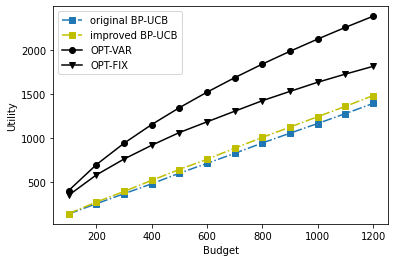

In [70]:
import matplotlib.pyplot as plt

budget = [100*i for i in range(1, 13)]

OPT_Offline_list=[]
OPT_VAR_list = []
OPT_FIX_list = []
BP_UCB_list = []
BP_UCB_v2_list = []
BP_DGREEDY_list = []
OMZ_list = []
#OMG_list=[]

N = 3000
K = 200
c_min = 0.2
alpha = 0.01


for cur_budget in budget:
    
    instance = Crowsensing_env(cur_budget, N, K, c_min, alpha)
    cost = instance.cost_list
    BP_UCB_value, _ = instance.BP_UCB()
    BP_UCB_v2_value, _ = instance.BP_UCB_v2()
    BP_DGREEDY_value, _ = instance.BP_DGREEDY()
    OPT_VAR_value = instance.OPT_VAR()
    OPT_FIX_value = instance.OPT_FIX()
    #_, _, OMZ_value = OMZ(cur_budget, cost)
    #_, _, OMG_value = OMG(cur_budget, cost)
    #_, _, OPTOffline_value = OPT_Offline(cur_budget, cost)
    
    #OMZ_list.append(OMZ_value)
    #OMG_list.append(OMG_value)
    #OPT_Offline_list.append(OPTOffline_value)
    BP_UCB_v2_list.append(BP_UCB_v2_value)
    BP_UCB_list.append(BP_UCB_value)
    BP_DGREEDY_list.append(BP_DGREEDY_value)
    OPT_VAR_list.append(OPT_VAR_value)
    OPT_FIX_list.append(OPT_FIX_value)

plt.plot(budget, BP_UCB_list, label = 'original BP-UCB', ls = '-.', marker = 's')
plt.plot(budget, BP_UCB_v2_list, label = 'improved BP-UCB', color = 'y', ls = '-.', marker = 's')
#plt.plot(budget, BP_DGREEDY_list, label = 'BP-DGREEDY', ls = '-.', marker = 's')
#plt.plot(budget, OMZ_list, label = 'OMZ', ls = '-.', marker = 's')
#plt.plot(budget, OMG_list, label = 'OMG', ls = '-.', marker = 's')
#plt.plot(budget, OPT_Offline_list, label = 'OPT-Offline', ls = '-.', marker = 's')
plt.plot(budget, OPT_VAR_list, label = 'OPT-VAR', ls = '-', color = 'black', marker = 'o')
plt.plot(budget, OPT_FIX_list, label = 'OPT-FIX', ls = '-', color = 'black', marker = 'v')
plt.legend()

plt.xlabel('Budget')
plt.ylabel('Utility')

Text(0, 0.5, 'Utility')

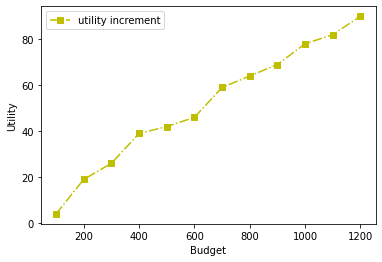

In [71]:
increment = np.array(BP_UCB_v2_list) - np.array(BP_UCB_list)
plt.plot(budget , increment, label = 'utility increment', color = 'y', ls = '-.', marker = 's')
plt.legend()

plt.xlabel('Budget')
plt.ylabel('Utility')